In [39]:
import wfdb
import wfdb.processing
from wfdb.processing import xqrs_detect
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.integrate import trapz
%matplotlib inline

# Using the wfdb library to read the data.

(array(['A', 'N'], dtype='<U1'), array([453,  39], dtype=int64))


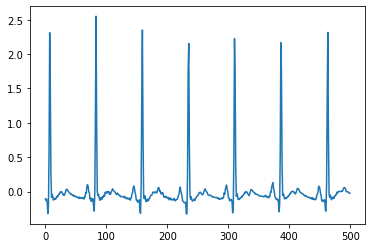

In [102]:
#main path for dataset
path = "apnea-ecg-database-1.0.0"

#read a sample record from dataset

Signal_record = wfdb.rdrecord(os.path.join(path, 'a04'), channels=[0])
outcome = wfdb.rdann(os.path.join(path,'a04'), extension='apn')
print(np.unique(outcome.symbol, return_counts=True))
#plot the start of the signal
plt.plot(Signal_record.p_signal[0:500])
plt.show()


## Data Labelling

In [110]:
def get_labels(signal,outcome):

    ecg_signal = signal.p_signal[:,0]
    
    # Get the annotation locations and types
    annotation_locs = outcome.sample
    annotation_types = outcome.symbol

    # Define the apnea event types
    apnea_types = ['H', 'A', 'O']

    # Label the ECG signals with the corresponding apnea events
    ecg_labels = []
    for i in range(len(ecg_signal)):
        if i in annotation_locs:
            idx = np.where(annotation_locs == i)[0][0]
            annotation_type = annotation_types[idx]
            if annotation_type in apnea_types:
                ecg_labels.append('A')
            else:
                ecg_labels.append('None')
        else:
            ecg_labels.append('None')

    return ecg_labels


ecg_labels = get_labels(signal=Signal_record,outcome=outcome)
labels_array = np.array(ecg_labels)
print(labels_array[:100])


['None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None']


# Data frame formation

In [62]:
def signals_to_dataframe(ecg_signals, ecg_labels):
    # Create a list of dictionaries to hold the data for each signal
    signal_data = []
    for i, signal in enumerate(ecg_signals):
        signal_dict = {
            'signal': signal,
            'label': ecg_labels[i]
        }
        signal_data.append(signal_dict)

    # Create a pandas DataFrame from the signal data
    df = pd.DataFrame(signal_data)
    return df

ecg_labels = get_labels(signal=Signal_record, outcome=outcome)
ecg_signals = Signal_record.p_signal[:, 0]
ecg_signals_df = signals_to_dataframe(ecg_signals, ecg_labels)
print(ecg_signals_df)

         signal label
0        -0.105  None
1        -0.130  None
2        -0.110  None
3        -0.165  None
4        -0.320  None
...         ...   ...
2979995   0.000  None
2979996   0.000  None
2979997   0.000  None
2979998   0.000  None
2979999   0.000  None

[2980000 rows x 2 columns]


# Time domain features + functions
[Source for features mentioned](https://www.mdpi.com/2076-3417/12/9/4218)

feature | Description
---  | ---
RRmean |	Mean of RR intervals 
RMSSD | Root mean square of differences between adjacent RR intervals 
SDNN | Standard deviation of RR intervals 
NN50 | Number of adjacent RR intervals exceeding 50 milliseconds 
pNN50 |	Ratio of NN50 to the number of RR intervals 
HR	| Mean of heart rates 


## These are secondary functions that are called in time_domain_features() and frequency_domain_features

In [87]:
def calc_RR_intervals(ecg_signal, fs):
    '''
    ecg_signal: time series data
    fs: sample rate
    return: rr_intervals
    the RR interval is the time between two consecutive R peaks, returned in milliseconds
    '''
    qrs_inds = xqrs_detect(ecg_signal, fs=fs)
    # Calculate R-R intervals
    rr_intervals = np.diff(qrs_inds) / fs  # convert to seconds
    return rr_intervals
#calculates the R amplitudes RAMP signal
def calc_RAMP(ecg_sig):
    # linear spaced vector between 0.5 pi and 1.5 pi 
    v = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)
    # use sine to approximate QRS feature
    peak_filter = np.sin(v)
    ecg_transformed = np.correlate(ecg_sig, peak_filter, mode="same")
    rr_peaks, _ = signal.find_peaks(ecg_transformed, distance=50)
    return rr_peaks


Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
RR intervals = [0.76 0.76 0.82 ... 0.9  0.96 0.87]
RR peaks =  [  13   89  165  240  316  392  469  546  624  700  776  852  928 1003
 1079 1155 1230 1306 1382 1458 1534 1610 1686 1762 1839 1915 1992 2068
 2145 2222 2298 2374 2451 2528 2604 2681 2758 2835 2912 2989 3066 3143
 3221 3298 3375 3452 3530 3607 3683 3760 3837 3913 3990 4067 4144 4221
 4298 4374 4451 4527 4604 4680 4757 4835 4912 4990 5068 5145 5221 5297
 5374 5450 5526 5602 5678 5755 5832 5908 5984 6059 6135 6210 6285 6359
 6434 6508 6582 6656 6730 6804 6878 6952 7026 7101 7176 7250 7325 7400
 7474 7549]


# Get time domain for one element (1-D)

In [54]:
# returns time domain features for a chunk of signal
def time_domain_features(ecg_signal, fs):
    '''
    ecg_signal: 1-D numpyarray time series ECG
    fs: sample rate
    return: RRmean, mean of RR intervals
            RRMSSD, Root mean square of differences between adjacent RR intervals
            SDNN, standard deviation of RR intervals
            NN50, Number of adjacent RR intervals differing by more than 50 ms
            pNN50, Proportion of NN50 divided by total number of RR intervals
            mean_HR Mean heart rate
    '''
    rr_intervals = calc_RR_intervals(ecg_signal, fs)
    RRmean = np.mean(rr_intervals)
    RRMSSD = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
    SDNN = np.std(rr_intervals)
    NN50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
    pNN50 = NN50 / len(rr_intervals)
    mean_HR = 60 / RRmean
    return RRmean, RRMSSD, SDNN, NN50, pNN50, mean_HR

In [121]:
a, b, c,d,e,f = time_domain_features(Signal_record.p_signal[:,0], Signal_record.fs)
print(a, b, c, d, e, f)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
0.987412244080024 0.1025121170151926 0.1641593585591422 0 0.0 60.764893649766556


# Frequency domain features

    Features | Description
	--- | ---
	VLF1, VLF2 | Very low frequency (0-0.04 Hz) component of the corresponding signal
	LF1, LF2 | Low frequency (0.04~0.15 Hz) component of the corresponding signal
	HF1, HF2 | High frequency (0.15~0.4 Hz) component of the corresponding signal
	LF/HF1, LF/HF2	| Ratio of LF to HF
	LFnorm1, LFnorm2 |	Normalized low frequency components
	HFnorm1, HFnorm2 |	Normalized high frequency components

Note: 1, 2 represent the frequency domain features of the RR interval and RAMP, respectively.

In [55]:
def frequency_domain(ecg_sig, fs):
    rri = calc_RR_intervals(ecg_sig, fs)
    rr_peaks = calc_RAMP(ecg_sig)
    # Estimate the spectral density using Welch's method
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    # calculate RR features
    fxx_RR, pxx_RR = signal.periodogram(x=rri, fs=fs)
    cond_vlf_RR = (fxx_RR >= 0) & (fxx_RR < 0.04)
    cond_lf_RR = (fxx_RR >= 0.04) & (fxx_RR < 0.15)
    cond_hf_RR = (fxx_RR >= 0.15) & (fxx_RR < 0.4)
    # calculate power in each band by integrating the spectral density 
    vlf_RR = trapz(pxx_RR[cond_vlf_RR], fxx_RR[cond_vlf_RR])
    lf_RR = trapz(pxx_RR[cond_lf_RR], fxx_RR[cond_lf_RR])
    hf_RR = trapz(pxx_RR[cond_hf_RR], fxx_RR[cond_hf_RR])
    # sum these up to get total power
    total_power_RR = vlf_RR + lf_RR + hf_RR
    # find which frequency has the most power in each band
    peak_vlf_RR = fxx_RR[cond_vlf_RR][np.argmax(pxx_RR[cond_vlf_RR])]
    peak_lf_RR = fxx_RR[cond_lf_RR][np.argmax(pxx_RR[cond_lf_RR])]
    peak_hf_RR = fxx_RR[cond_hf_RR][np.argmax(pxx_RR[cond_hf_RR])]
    lf_norm_RR = lf_RR/ total_power_RR
    hf_norm_RR = hf_RR / total_power_RR
    
    #calculate RAMP features
    fxx_RAMP, pxx_RAMP = signal.periodogram(x=rr_peaks, fs=fs)
    cond_vlf_RAMP = (fxx_RAMP >= 0) & (fxx_RAMP < 0.04)
    cond_lf_RAMP = (fxx_RAMP >= 0.04) & (fxx_RAMP < 0.15)
    cond_hf_RAMP = (fxx_RAMP>= 0.15) & (fxx_RAMP < 0.4)
    # calculate power in each band by integrating the spectral density 
    vlf_RAMP = trapz(pxx_RAMP[cond_vlf_RAMP], fxx_RAMP[cond_vlf_RAMP])
    lf_RAMP = trapz(pxx_RAMP[cond_lf_RAMP], fxx_RAMP[cond_lf_RAMP])
    hf_RAMP = trapz(pxx_RAMP[cond_hf_RAMP], fxx_RAMP[cond_hf_RAMP])
    # sum these up to get total power
    total_power_RAMP = vlf_RAMP + lf_RAMP + hf_RAMP
    # find which frequency has the most power in each band
    peak_vlf_RAMP = fxx_RAMP[cond_vlf_RAMP][np.argmax(pxx_RAMP[cond_vlf_RAMP])]
    peak_lf_RAMP = fxx_RAMP[cond_lf_RAMP][np.argmax(pxx_RAMP[cond_lf_RAMP])]
    peak_hf_RAMP = fxx_RAMP[cond_hf_RAMP][np.argmax(pxx_RAMP[cond_hf_RAMP])]
    lf_norm_RAMP = lf_RAMP / total_power_RAMP
    hf_norm_RAMP = hf_RAMP / total_power_RAMP  


    #map values to aforementioned values
    VLF1 = vlf_RR; VLF2 = vlf_RAMP # VLF1, VLF2 | Very low frequency (0-0.04 Hz) component of the corresponding signal
    LF1 = lf_RR; LF2 = lf_RAMP # LF1, LF2 | Low frequency (0.04~0.15 Hz) component of the corresponding signal
    HF1 = hf_RR; HF2 = hf_RAMP # HF1, HF2 | High frequency (0.15~0.4 Hz) component of the corresponding signal

    LF_HF1 = lf_RR/hf_RR; LF_HF2 = lf_RAMP/hf_RAMP # LF/HF1, LF/HF2	| Ratio of LF to HF
    LF_NORM1 = lf_norm_RR; LF_NORM2 = lf_norm_RAMP# LFnorm1, LFnorm2 |	Normalized low frequency components
    HF_NORM1 = hf_norm_RR; HF_NORM2 = hf_norm_RAMP # HFnorm1, HFnorm2 |	Normalized high frequency components
    return  [VLF1, VLF2, LF1, LF2, HF1, HF2, LF_HF1, LF_HF2, LF_NORM1, LF_NORM2, HF_NORM1, HF_NORM2]

results = frequency_domain(Signal_record.p_signal[:,0], Signal_record.fs)
print(results)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[0.005496283843495939, 706945036269.3286, 0.00039639219065404363, 20444735810.202282, 0.0003350036802827222, 4630210108.847871, 1.1832472715509077, 4.415509302943818, 0.06365006050895666, 0.027929204540404217, 0.0537926957782283, 0.0063252509788132094]


In [115]:
# # Get a list of all record names in the database
# record_names = wfdb.get_record_list('apnea-ecg')

# # Initialize an empty list to store the ECG data arrays
# ecg_data = []

# # Loop over all record names and read the ECG signal data for each record
# for record_name in record_names:
#     # Read the ECG signal data for the current record
#     signal_record = wfdb.rdrecord(os.path.join(path, record_name), channels=[0])
#     ecg_signal = signal_record.p_signal[:,0]
#     # Append the ECG signal data to the list of data arrays
#     ecg_data.append(ecg_signal)



# # Convert the list of data arrays to a NumPy array
# ecg_data_array = np.array(ecg_data)


# # Print the shape of the resulting array
# print(ecg_labels[:100])


['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']


C:\Users\hazem\AppData\Local\Temp\ipykernel_24760\2334726880.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ecg_data_array = np.array(ecg_data)
